<a href="https://colab.research.google.com/github/jollyredflames/GAN-CXR-Anomaly-Detection/blob/master/CSC420_Project_COVIDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The following lines outline the efforts we have taken to repurpose the conditional-adversarial model presented in the pix2pix paper as an anomaly detection model to detect the cases of viral pneumonia from the chest X-ray images. 

The original model is aimed at a way of style-transfer between pairs of images. For example, the model can be trained on the pairs of aerial images and maps, so in the deployment, it draws maps from aerial images. 

We have made changes to the original pix2pix model that we discuss here:

* The pix2pix model's Generator utilizes the UNet design where skip connections are shared between the encoder/decoder layers. This makes sense in the context of style transfer since we want the network to be able to utilize the information from the input image to come up with the output. However, in the Anomaly Detection context, we want the network to learn to reconstruct CXR images by itself. This means the network will, in theory, do a good job of reconstructing the images it has seen in training ("normal" cases) and it will do poorly for the category of images it does not encounter in training ("abnormal cases").

* Both pix2pix model and our model utilize convolutional autoencoders. However, the pix2pix model shrinks the images a lot before the autoencoder level. However, we want the network to focus on the "local" features of images. Therefore, the number of layers in our Generator has been reduced to 4 on each side of the autoencoder. Since the Discriminator is also just a simple convolutional neural network, we have also reduced the number of layers too to reflect the changes for the Generator. 

# Related Work

Zhang, J et al [1] has been the inspiration behind the work we have done here. They propose the confidence-aware anomaly detection (CAAD) model that works by a convolutional feature detector model feeding into an anomaly detection module and a confidence prediction module that works together to classify instances of healthy control, viral-pneumonia and non-viral pneumonia. Similar to our proposed model, CAAD utilizes an anomaly detection module that enables it to potentially train in the absence of viral pneumonia CXR cases. We have taken CAAD as the state-of-the-art model with a sweeping 87.47% AUC when the confidence prediction module and the anomaly detection module in it work in tandem. 

# Disscussion 

# Documented Code

## Imports

In [4]:
import torch 
print('torch version: ', torch.__version__)
import torchvision
print('torchvision version: ', torchvision.__version__)


from torch.utils import data
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import re
import zipfile
import random
import cv2

import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics


import glob, inspect, time, math
from numpy import savetxt

from torch.nn import functional as F
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

torch.autograd.set_detect_anomaly(True)

torch version:  1.6.0+cu101
torchvision version:  0.7.0+cu101


## Preparing the Dataset

Our current model utlizes a resized version of [CoronaHack](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset). To use the CXR images in our model, all images have been resized to 256*256. For the model training purposes we utlized Google Colab. The data has been uploaded to Google Drive as a zip file. Here we download the data and unzip it.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data = os.path.join('.', 'drive')
data = os.path.join(data, 'My Drive')
data_folder = os.path.join(data, 'CSC420_Project')
data_zip = os.path.join(data_folder, 'CoronaHack_Resized.zip')

zip_ref = zipfile.ZipFile(data_zip, 'r')
zip_ref.extractall('/content/CoronaHack')
zip_ref.close()

In [7]:
pic_path = '/content/CoronaHack/CoronaHack_Resized'

print("Total number of CXR images: {}".format(len(os.listdir(pic_path))))

Total number of CXR images: 5910


## Model Analytics and Logging

The training of neural networks is a costly procedure. We have designed a custome made system of saving model parameters in between training, test snapshots, and train summeries. 

The block below sets the model analytic paths, create the folders on Google Drive and write the headlines for CSV files that record the test/train snapshots. 

In [8]:
## Change this based on you model name ##
model_name = "f1-AnomalyDetect"
#####################################

def make_dir(path):
    try: os.mkdir(path)
    except: 
      pass


save_path = F"/content/drive/My Drive/CSC420_Project/Models/{model_name}"
param_save_path = save_path + "/params" 
snapshots_save_path = save_path + "/snapshots" 
results_path = save_path + "/results"

OnTrain_summary_path = save_path+"/01-OnTrain-summary.csv"
OnTestsnapshots_summary_path = save_path+"/02-OnTest-snapshots-summary.csv"
    


make_dir(results_path)
make_dir(save_path)
make_dir(param_save_path)
make_dir(snapshots_save_path)

result_list = ["tr_restoring", "pca_latent_ontest", "tsne_latent_ontest"]
for result_name in result_list: make_dir(path=os.path.join(results_path, result_name))

## Run this once for each model. It will re-write the files ##
'''
fcsv = open(OnTrain_summary_path, "w")
fcsv.write("epoch,loss_D,loss_G,loss_D_real,loss_D_fake,loss_G_fake,loss_G_L1\n")
fcsv.close()



fcsv = open(OnTestsnapshots_summary_path, "w")
fcsv.write("epoch,G_Normal_loss_Mean,G_AbNormal_loss_Mean,D_Normal_loss_Mean,D_AbNormal_loss_Mean,G_Normal_loss_SD,G_AbNormal_loss_SD,D_Normal_loss_SD,D_AbNormal_loss_SD,G_AUC,D_AUC\n")
fcsv.close()
'''

'\nfcsv = open(OnTrain_summary_path, "w")\nfcsv.write("epoch,loss_D,loss_G,loss_D_real,loss_D_fake,loss_G_fake,loss_G_L1\n")\nfcsv.close()\n\n\n\nfcsv = open(OnTestsnapshots_summary_path, "w")\nfcsv.write("epoch,G_Normal_loss_Mean,G_AbNormal_loss_Mean,D_Normal_loss_Mean,D_AbNormal_loss_Mean,G_Normal_loss_SD,G_AbNormal_loss_SD,D_Normal_loss_SD,D_AbNormal_loss_SD,G_AUC,D_AUC\n")\nfcsv.close()\n'

## Dataset Class

Managing memory allocation is an important part of training any serious neural network. Unlike smaller datasets like MNIST, it is not possible to load the totality of CoronaHack on to the RAM prior to the training. 

Instead, we have designed and written a custome made dataset class. Out data directory consists of a folder of CXR images, and a CSV file preserving the path and lable information for each image. 

The Dataset object is responsible for loading train/test images in batches, splitting the data into folds (the design supports kfold cross-validation), and normalizing the data.


In [9]:
data_path = os.path.join(os.getcwd(),  'CoronaHack')

data_frame_path = os.path.join(data_path, 'dataset.csv')
images_path = os.path.join(data_path, 'CoronaHack_Resized')


class Dataset(object):

    def __init__(self, normalize=True, normal=['Normal'], ab_normal=['Virus'], n_splits=3, n_exp=0):

        print("\nInitializing Dataset...")

        data_frame = pd.read_csv(data_frame_path)

        self.data_frame = data_frame
        self.normal_labels = normal
        self.ab_normal_labels = ab_normal
        self.normal_df = shuffle(data_frame.loc[data_frame['label'].isin(normal)], random_state=42)
        self.ab_normal_df = shuffle(data_frame.loc[data_frame['label'].isin(ab_normal)], random_state=42)

        kf_normal = KFold(n_splits=n_splits, random_state=42)

        self.trains = []
        self.tests_normals = []
        self.tests_ab_normal = []

        for train_index, test_index in kf_normal.split(self.normal_df):
          self.trains.append(train_index)
          self.tests_normals.append(test_index)

        for train_index, test_index in kf_normal.split(self.ab_normal_df):
          self.tests_ab_normal.append(test_index)

        normal_df_train, normal_df_test = self.normal_df.iloc[self.trains[n_exp]], self.normal_df.iloc[self.tests_normals[n_exp]]
        ab_normal_df_test = self.ab_normal_df.iloc[self.tests_ab_normal[n_exp]]
        
        #train_df, test_df = train_test_split(normal_df, test_size=0.33)

        self.train_df = normal_df_train
        self.test_df = shuffle(pd.concat([ab_normal_df_test, normal_df_test]), random_state=42)
        print("Running experiment number {} out of {} ----  Train Cases: {} / Test Cases: {} Out of which {} are COVID"
              .format(n_exp, n_splits-1, self.train_df.shape[0], self.test_df.shape[0], ab_normal_df_test.shape[0]))


        self.normalize = normalize


        self.num_train, self.num_test = self.train_df.shape[0], self.test_df.shape[0]
        self.idx_train, self.idx_test = 0, 0

        sample_image = cv2.imread(os.path.join(images_path, self.train_df.iloc[0]['cxr_img']))

        #self.height = sample_image.shape[0]
        #self.width = sample_image.shape[1]

        self.height = 256
        self.width = 256
        self.channel = 3


        self.num_class = len(normal) + 1
        self.min_val, self.max_val = sample_image.min(), sample_image.max()

        print("Data Summery")
        print("Number of Training Cases: {}".format(self.num_train))
        print("Total Number of Test Cases: {}, Abnormal Cases: {}".format(self.num_test, ab_normal_df_test.shape[0]))
        print("Shape  Height: %d, Width: %d, Channel: %d" %(self.height, self.width, self.channel))
        print("Value  Min: %.3f, Max: %.3f" %(self.min_val, self.max_val))
        print("Number of classes:  %d" %(self.num_class))
        print("Normalization: %r" %(self.normalize))
        if(self.normalize): print("(from %.3f-%.3f to %.3f-%.3f)" %(self.min_val, self.max_val, 0, 1))


    def reset_idx(self): self.idx_train, self.idx_test = 0, 0

    def next_train(self, batch_size=1):


        start, end = self.idx_train, self.idx_train+batch_size

        terminator = False
        if(end >= self.num_train):
            terminator = True
            self.train_df = shuffle(self.train_df)
            start = 0
            end = batch_size

        self.idx_train = end

        train_images = np.zeros((batch_size, self.height, self.width, self.channel))
        train_labels = np.zeros((batch_size), dtype=int)

        for i in range(start, end):
            img_path = self.train_df.iloc[i]['cxr_img']
            img_path = os.path.join(images_path, img_path)
            train_images[i-start] = cv2.imread(img_path)
            train_labels[i-start] = 0


        train_images = np.ndarray.astype(train_images, np.float32)


        if(self.normalize):
            min_x, max_x = train_images.min(), train_images.max()
            train_images = (train_images - min_x) / (max_x - min_x)

        train_images_torch = torch.from_numpy(np.transpose(train_images, (0, 3, 1, 2)))
        train_labels_torch = torch.from_numpy(train_labels)

        return train_images, train_images_torch, train_labels, train_labels_torch, terminator


    def next_test(self, batch_size=1):

        start, end = self.idx_test, self.idx_test + batch_size

        terminator = False
        if (end >= self.num_test):
            terminator = True
            self.test_df = shuffle(self.test_df)
            start = 0
            end = batch_size

        self.idx_test = end

        test_images = np.zeros((batch_size, self.height, self.width, self.channel))
        test_labels = np.zeros((batch_size), dtype=int)
        for i in range(start, end):
            img_path = self.test_df.iloc[i]['cxr_img']
            img_path = os.path.join(images_path, img_path)
            test_images[i - start] = cv2.resize(cv2.imread(img_path), (256,256), interpolation = cv2.INTER_AREA)

            label = self.test_df.iloc[i]['label']
            test_labels[i - start] = 0
            if(label in self.ab_normal_labels):
                #abnormal is 1
                test_labels[i - start] = 1


        test_images = np.ndarray.astype(test_images, np.float32)

        if(self.normalize):
            min_x, max_x = test_images.min(), test_images.max()
            test_images = (test_images - min_x) / (max_x - min_x)

        test_images_torch = torch.from_numpy(np.transpose(test_images, (0, 3, 1, 2)))
        test_labels_torch = torch.from_numpy(test_labels)

        return test_images, test_images_torch, test_labels, test_labels_torch, terminator

## Neural Networks

### The Generator

In [10]:
import torch
from torch import nn

class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.size(0), -1)
  
class Generator(nn.Module):
    def __init__(self, k_size=4):
        super(Generator, self).__init__()
        self.k_size = k_size
        # enc
        self.enc_bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=self.k_size, stride=2, padding=2)

        self.enc_bn2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=self.k_size, stride=2, padding=2)

        self.enc_bn3 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=self.k_size, stride=2, padding=2)

        self.enc_bn4 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=self.k_size, stride=2, padding=2)


        self.flat = Flatten()
        self.en_linear1 = nn.Linear(17*17*512, 1024)
        self.en_linear2 = nn.Linear(1024, 128)


        #decode        
        self.dec_linear1 = nn.Linear(128, 1024)
        self.dec_linear2 = nn.Linear(1024,17*17*512)

        self.dec_bn1 = nn.BatchNorm2d(512)
        self.convT1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=self.k_size, stride=2, padding=2, output_padding=1)

        self.dec_bn2 = nn.BatchNorm2d(256)
        self.convT2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=self.k_size, stride=2, padding=2, output_padding=1)

        self.dec_bn3 = nn.BatchNorm2d(128)
        self.convT3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=self.k_size, stride=2, padding=2, output_padding=1)

        self.dec_bn4 = nn.BatchNorm2d(64)
        self.convT4 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=self.k_size, stride=2, padding=2)



        self.leaky_relu = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2)


        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)




    def encode(self, x):

      x = self.enc_bn1(x)
      x = self.conv1(x)
      x = self.leaky_relu(x)

      x = self.enc_bn2(x)
      x = self.conv2(x)
      x = self.leaky_relu(x)

      x = self.enc_bn3(x)
      x = self.conv3(x)
      x = self.leaky_relu(x)
      
      x = self.enc_bn4(x)
      x = self.conv4(x)
      x = self.leaky_relu(x)


      x = self.flat(x)
      x = self.en_linear1(x)
      x = self.leaky_relu(x)
      x = self.en_linear2(x)

      return(x)

    def decode(self, x):
      x = self.dec_linear1(x)
      x = self.leaky_relu(x)
      x = self.dec_linear2(x)

      x = x.reshape(x.size(0), 512, 17, 17)  

      x = self.dec_bn1(x)
      x = self.convT1(x)
      x = self.leaky_relu(x)

      x = self.dec_bn2(x)
      x = self.convT2(x)
      x = self.leaky_relu(x)

      x = self.dec_bn3(x)
      x = self.convT3(x)
      x = self.leaky_relu(x)

      x = self.dec_bn4(x)
      x = self.convT4(x)
      x = self.leaky_relu(x)

      return x



    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)

        return x

### The Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3*2,  64, 4, stride=2, padding=2)
        self.conv2 = nn.Conv2d( 64, 128, 4, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=2)        
        self.conv_bn1 = nn.BatchNorm2d(64)
        self.conv_bn2 = nn.BatchNorm2d(128)
        self.conv_bn3 = nn.BatchNorm2d(256)        
        self.conv_bn4 = nn.BatchNorm2d(512) 
        self.fc = nn.Linear(512*17*17, 1)
        self.conv_act = nn.LeakyReLU(0.2)
        self.op_act = nn.Sigmoid()
        
    def forward(self, x):
        # enc
        x = self.conv_bn1(self.conv_act(self.conv1(x)))  
        x = self.conv_bn2(self.conv_act(self.conv2(x)))    
        x = self.conv_bn3(self.conv_act(self.conv3(x)))  
        x = self.conv_bn4(self.conv_act(self.conv4(x)))  
        x = self.fc(x.reshape(x.shape[0], -1))             
        return self.op_act(x)
    

## Forward-Pass, Objective Function Computations

This forward-pass, objective function implements what has been proposed in the pix2pix paper.

In [12]:
def forward_n_get_loss(img, G, D, c=100):
    img_hat = G(img) 
    orig_pair = torch.cat([img, img], 1)
    hat_pair = torch.cat([img_hat, img], 1)
    prob_orig, prob_hat = D(orig_pair), D(hat_pair).detach()
    prob_hat_G = prob_hat.clone()

    # loss_D
    loss_D_orig = nn.BCELoss()(prob_orig, torch.ones_like(prob_orig))
    loss_D_hat = nn.BCELoss()(prob_hat, torch.zeros_like(prob_hat))
    loss_D = (loss_D_orig + loss_D_hat) *0.5
    # loss_G
    loss_G_hat = nn.BCELoss()(prob_hat, torch.ones_like(prob_hat_G))
    loss_G_L1 = nn.L1Loss()(img_hat, img)
    loss_G = loss_G_hat + c*loss_G_L1
    return loss_D, loss_G, loss_D_orig, loss_D_hat, loss_G_hat, loss_G_L1



## Utilities 

The following block implements a series of functions that help us with the training, testing, and logging process. 

In [13]:
'''
def gray2rgb(gray):

    rgb = np.ones((gray.shape[0], gray.shape[1], 3)).astype(np.float32)
    rgb[:, :, 0] = gray[:, :, 0]
    rgb[:, :, 1] = gray[:, :, 0]
    rgb[:, :, 2] = gray[:, :, 0]

    return rgb
'''

def dat2canvas(data):

    numd = math.ceil(np.sqrt(data.shape[0]))
    [dn, dh, dw, dc] = data.shape
    canvas = np.ones((dh*numd, dw*numd, dc)).astype(np.float32)

    for y in range(numd):
        for x in range(numd):
            try: tmp = data[x+(y*numd)]
            except: pass
            else: canvas[(y*dh):(y*dh)+256, (x*dw):(x*dw)+256, :] = tmp
    #if(dc == 1):
     #   canvas = gray2rgb(gray=canvas)

    return canvas

def save_img(contents, names=["", "", ""], savename=""):

    num_cont = len(contents)
    plt.figure(figsize=(5*num_cont+2, 5))

    for i in range(num_cont):
        plt.subplot(1,num_cont,i+1)
        plt.title(names[i])
        plt.imshow(dat2canvas(data=contents[i]))

    plt.tight_layout()
    plt.savefig(savename)
    plt.close()

def discrete_cmap(N, base_cmap=None):

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)

    return base.from_list(cmap_name, color_list, N)

# Saves a latent plot, used both for t-sne plotting and PCA plots
def latent_plot(latent, y, n, title, savename=""):

    plt.figure(figsize=(6, 5))
    plt.scatter(latent[:, 0], latent[:, 1], c=y, \
        marker='o', edgecolor='none', cmap=discrete_cmap(n, 'jet'))
    plt.colorbar(ticks=range(n))
    plt.grid()
    plt.tight_layout()
    plt.title(title)
    plt.savefig(savename)
    plt.close()

def save_graph(contents, xlabel, ylabel, savename):

    np.save(savename, np.asarray(contents))
    plt.clf()
    plt.rcParams['font.size'] = 15
    plt.plot(contents, color='blue', linestyle="-", label="loss")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout(pad=1, w_pad=1, h_pad=1)
    plt.savefig("%s.png" %(savename))
    plt.close()

def tens2nparr(input):

    input = input.cpu()
    output = input.detach().numpy()
    return output

# Computes Mean Squared Loss between two sets of images. This meassure is used for anomaly detection
def restore_loss_functions(x, x_hat):

    x, x_hat = x.cpu(), x_hat.cpu()
    criterion = torch.nn.MSELoss()
    restore_loss = criterion(x_hat, x)
    return restore_loss

def get_device():
  device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Trains the models, save a recounstruction plot at the beginning of each epoch
# It is also capable of loading previously saved model parameters. 
# see *param_save_path* in the first code block
def training(G, D, dataset, epochs, batch_size, load=False, snapshot=True):

    # if a model is loaded, this number reflects the epochs of the previous training
    epoch_offset = 0
    if(load):
      pre_trained_models = os.listdir(param_save_path)

      param_G = os.path.join(param_save_path, pre_trained_models[-2])
      param_D = os.path.join(param_save_path, pre_trained_models[-1])
      print('=======')
      print(param_D)
      print(param_G)
      print('=======')

      G.load_state_dict(torch.load(param_G))
      D.load_state_dict(torch.load(param_D))
      print("model loaded succesffully")

      epoch_offset = int(re.findall(r'\d+', pre_trained_models[-1])[0])

      print("---> Model was previously trained on {}-epochs".format(epoch_offset))


    print("\n<Training to new %d epochs (%d of minibatch size)>" %(epochs, batch_size))

    device = get_device()


    start_time = time.time()

    iteration = 0

    test_sq = 10
    test_size = test_sq**2
    list_recon = []
    restore_error = 0

    loss2npval = lambda loss : np.mean(loss.cpu().data.numpy()).round(4)
    loss_names = ["loss_D", "loss_G", "loss_D_real", "loss_D_fake",  \
                  "loss_G_fake", "loss_G_L1"]
    update_DnG_together = True
    G.train()
    D.train()

    for epoch in range(epoch_offset, epoch_offset + epochs):


        x_tr, x_tr_torch, y_tr, y_tr_torch, _ = dataset.next_train(batch_size=test_size) # Initial batch


        x_restore = G(x_tr_torch.cuda())

        x_restore = np.transpose(tens2nparr(x_restore), (0, 2, 3, 1))


        save_img(contents=[x_tr, x_restore, (x_tr-x_restore)**2], \
            names=["Input\n(x)", "Restoration\n(x to x-hat)", "Difference"], \
            savename=os.path.join(results_path, "tr_restoring", "%d.png" %(epoch)))



        while(True):
            if(iteration % 10 == 0):
                print("->Epoch {}, Training Index {}, Latest RestoreError {}".format(epoch, dataset.idx_train, restore_error))

            x_tr, x_tr_torch, y_tr, y_tr_torch, terminator = dataset.next_train(batch_size)

            x_tr_torch = x_tr_torch.cuda()

            # forward and get loss
            c = 100
            losses = forward_n_get_loss(x_tr_torch, G, D, c=c )

            update_D, update_G = (True, True) if update_DnG_together  \
            else ((epo+batch_No)%2!=0, (epo+batch_No)%2==0  )
            
            # update D
            if update_D:
                optimizer_D.zero_grad()
                losses[0].backward(retain_graph=True)
                optimizer_D.step()
                
            # update G
            if update_G:
                optimizer_G.zero_grad()
                losses[1].backward()
                optimizer_G.step()


            

            x_hat = G(x_tr_torch.to(device))

            restore_error = restore_loss_functions(x=x_tr_torch, x_hat=x_hat)
            list_recon.append(restore_error.item())

            x_hat = np.transpose(tens2nparr(x_hat), (0, 2, 3, 1))


            iteration += 1
            if(terminator): break
                
        loss_vals = map(loss2npval, losses)
        loss_info = dict(zip(loss_names,loss_vals))
        print("[{}] {}, time_cost:" \
              .format( epoch, loss_info))
        
        with open(OnTrain_summary_path, "a") as fcsv:
          fcsv.write("%d,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f\n" \
          %(epoch, losses[0], losses[1], losses[2], losses[3],losses[4],losses[5]))
        
        if(epoch % 5 == 0):
          torch.save(G.state_dict(), param_save_path+"/params-epoch%d-G" %(epoch))
          torch.save(D.state_dict(), param_save_path+"/params-epoch%d-D" %(epoch))

          if(snapshot):
            dataset.reset_idx()
            snapshot_onTest(G, D, dataset, epoch)
            torch.cuda.empty_cache()


    elapsed_time = time.time() - start_time
    print("Elapsed: "+str(elapsed_time))

# This function tests the models on the train set of the dataset and logs a bunch of plots and analytics
def snapshot_onTest(G, D, dataset, epoch):

    G_scores_normal, G_scores_abnormal = [], []
    D_scores_normal, D_scores_abnormal = [],[]
    latent_vectors, labels = [], []
    G_scores = []
    D_scores = []


    snap_fcsv = open(snapshots_save_path+"/01-OnTest-epoch{}-snapshot.csv".format(epoch), "w")

    snap_fcsv.write("class,G_score,D_score\n")


    print("Test SnapShot:")
    while(True):
        x, x_torch, y, y_torch, terminator = dataset.next_test(1) # y_te does not used in this prj.

        x_hat = G(x_torch.cuda())
        x_enc = tens2nparr(G.encode(x_torch.cuda()))[0]
        G_recons_error = restore_loss_functions(x=x_torch, x_hat=x_hat)
        x_G_score = G_recons_error.item()

        pair = torch.cat([x_torch.cuda(), x_hat], 1)
        x_D_score = D(pair.cuda()).item()


        labels.append(y[0])
        latent_vectors.append(x_enc)
        G_scores.append(x_G_score)
        D_scores.append(x_D_score)

        if (y[0] == 0): 
          G_scores_normal.append(x_G_score)
          D_scores_normal.append(x_D_score)
        else:
          G_scores_abnormal.append(x_G_score)
          D_scores_abnormal.append(x_D_score)

        snap_fcsv.write("%d,%.7f,%.7f\n" %(y, x_G_score, x_D_score))

        if(terminator): break


    # Saving the latent plots
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)

    latent_vectors, labels = np.array(latent_vectors), np.array(labels)

    pca_features = pca.fit_transform(latent_vectors)
    tsne_features = tsne.fit_transform(latent_vectors)

    latent_plot(latent=pca_features, y=labels, n=dataset.num_class, title='PCA Plot-epoch%d' %(epoch),\
            savename=os.path.join(results_path, 'pca_latent_ontest', '%d.png' %(epoch)))

    latent_plot(latent=tsne_features, y=labels, n=dataset.num_class, title='t-SNE Plot-epoch%d' %(epoch),\
        savename=os.path.join(results_path, 'tsne_latent_ontest', '%d.png' %(epoch)))
    

    
    G_fpr, G_tpr, G_thresholds = metrics.roc_curve(labels, G_scores, pos_label=1)
    G_AUC = metrics.auc(G_fpr, G_tpr)


    D_fpr, D_tpr, D_thresholds = metrics.roc_curve(labels, D_scores, pos_label=1)
    D_AUC = metrics.auc(D_fpr, D_tpr)

    D_ins_fpr, D_ins_tpr, D_ins_thresholds = metrics.roc_curve(labels, [1 - dscore for dscore in D_scores], pos_label=1)
    D_ins_AUC = metrics.auc(D_fpr, D_tpr)
 

    G_scores_normal = np.asarray(G_scores_normal)
    G_scores_abnormal = np.asarray(G_scores_abnormal)

    D_scores_normal = np.asarray(D_scores_normal)
    D_scores_abnormal = np.asarray(D_scores_abnormal)

    G_normal_avg, G_normal_std = np.average(G_scores_normal), np.std(G_scores_normal)
    G_abnormal_avg, G_abnormal_std = np.average(G_scores_abnormal), np.std(G_scores_abnormal)


    D_normal_avg, D_normal_std = np.average(D_scores_normal), np.std(D_scores_normal)
    D_abnormal_avg, D_abnormal_std = np.average(D_scores_abnormal), np.std(D_scores_abnormal)


    print("EPOCH: {}".format(epoch))

    print(" Generator Stats: ")
    print("   G-Noraml  avg: %.5f, std: %.5f" %(G_normal_avg, G_normal_std))
    print("   G-Abnoraml  avg: %.5f, std: %.5f" %(G_abnormal_avg, G_abnormal_std))
    print('   G-AUC for epoch{}: {:.5f}'.format(epoch, G_AUC))


    print(" Discriminator Stats: ")
    print("   D-Noraml  avg: %.5f, std: %.5f" %(D_normal_avg, D_normal_std))
    print("   D-Abnoraml  avg: %.5f, std: %.5f" %(D_abnormal_avg, D_abnormal_std))
    print("   D-AUC for epoch{}: {:.5f}".format(epoch, D_AUC))

    print("   D-inverse-AUC for epoch{}: {:.5f}".format(epoch, D_ins_AUC))

    with open(OnTestsnapshots_summary_path, "a") as fcsv:
      fcsv.write("%d,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f\n" \
                 %(epoch, G_normal_avg, G_abnormal_avg, D_normal_avg, D_abnormal_avg, G_normal_std, G_abnormal_std, D_normal_std, D_abnormal_std, G_AUC, D_AUC))
      



## Experiment

### Create instances of our neural networks

In [14]:
# build model 
use_cuda = torch.cuda.is_available()
print('use_cuda:', use_cuda)
if use_cuda:
    G = Generator().cuda()
    D = Discriminator().cuda()
else:
    G = Generator()
    D = Discriminator()  

use_cuda: True


### Initialize the weights and bias terms by random distributoions

In [15]:
# initialize weights
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.normal_(0, 0.02)
G.apply(init_weights)
D.apply(init_weights)
print(G.conv1.weight.data.mean().mean())# close to 0.00
print(G.conv1.weight.data.std().mean())# close to 0.02

tensor(3.1138e-05, device='cuda:0')
tensor(0.0199, device='cuda:0')


### Wanna know the number of parameters?

In [16]:
num_p = 0
for idx_m, model in enumerate([G, D]):
    for p in model.parameters():
        num_p += p.numel()
    #print(model)
print("The number of parameters: %d" %(num_p))

The number of parameters: 311875658


### Optimizers

In [17]:
from torch.optim import Adam
optimizer_G = Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

### Training 

In [18]:
# an instance of the dataset object
dataset = Dataset(n_exp=0, n_splits=3)


Initializing Dataset...
Running experiment number 0 out of 2 ----  Train Cases: 1050 / Test Cases: 1045 Out of which 519 are COVID
Data Summery
Number of Training Cases: 1050
Total Number of Test Cases: 1045, Abnormal Cases: 519
Shape  Height: 256, Width: 256, Channel: 3
Value  Min: 0.000, Max: 254.000
Number of classes:  2
Normalization: True
(from 0.000-254.000 to 0.000-1.000)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
# training
training(G, D, dataset, epochs=105, batch_size=30, load=True)

/content/drive/My Drive/CSC420_Project/Models/f1-AnomalyDetect/params/params-epoch85-D
/content/drive/My Drive/CSC420_Project/Models/f1-AnomalyDetect/params/params-epoch85-G
model loaded succesffully
---> Model was previously trained on 85-epochs

<Training to new 105 epochs (30 of minibatch size)>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 85, Training Index 100, Latest RestoreError 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2617: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  ret = torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))


->Epoch 85, Training Index 400, Latest RestoreError 0.0015636328607797623
->Epoch 85, Training Index 700, Latest RestoreError 0.0013669495237991214
->Epoch 85, Training Index 1000, Latest RestoreError 0.0013613873161375523
[85] {'loss_D': 6.6674, 'loss_G': 2.4757, 'loss_D_real': 0.0, 'loss_D_fake': 13.3349, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0248}, time_cost:
Test SnapShot:
EPOCH: 85
 Generator Stats: 
   G-Noraml  avg: 0.00879, std: 0.00553
   G-Abnoraml  avg: 0.01719, std: 0.01498
   G-AUC for epoch85: 0.73422
 Discriminator Stats: 
   D-Noraml  avg: 0.99999, std: 0.00001
   D-Abnoraml  avg: 0.99998, std: 0.00007
   D-AUC for epoch85: 0.33425
   D-inverse-AUC for epoch85: 0.33425


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 86, Training Index 340, Latest RestoreError 0.0014661785680800676
->Epoch 86, Training Index 640, Latest RestoreError 0.0013382360339164734
->Epoch 86, Training Index 940, Latest RestoreError 0.0014456937788054347
[86] {'loss_D': 9.5102, 'loss_G': 2.609, 'loss_D_real': 0.0, 'loss_D_fake': 19.0203, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0261}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 87, Training Index 310, Latest RestoreError 0.0014345523668453097
->Epoch 87, Training Index 610, Latest RestoreError 0.0014164105523377657
->Epoch 87, Training Index 910, Latest RestoreError 0.001329816528595984
[87] {'loss_D': 8.0167, 'loss_G': 2.6822, 'loss_D_real': 0.0, 'loss_D_fake': 16.0334, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0268}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 88, Training Index 280, Latest RestoreError 0.001253295224159956
->Epoch 88, Training Index 580, Latest RestoreError 0.0013776002451777458
->Epoch 88, Training Index 880, Latest RestoreError 0.001330539584159851
[88] {'loss_D': 9.5151, 'loss_G': 2.4901, 'loss_D_real': 0.0, 'loss_D_fake': 19.0302, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0249}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 89, Training Index 250, Latest RestoreError 0.0012238265480846167
->Epoch 89, Training Index 550, Latest RestoreError 0.001469513401389122
->Epoch 89, Training Index 850, Latest RestoreError 0.0013815020211040974
[89] {'loss_D': 8.377, 'loss_G': 2.4059, 'loss_D_real': 0.0, 'loss_D_fake': 16.754, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0241}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 90, Training Index 220, Latest RestoreError 0.0012981881154701114
->Epoch 90, Training Index 520, Latest RestoreError 0.0013468301622197032
->Epoch 90, Training Index 820, Latest RestoreError 0.001175544923171401
[90] {'loss_D': 6.8123, 'loss_G': 2.7249, 'loss_D_real': 0.0, 'loss_D_fake': 13.6246, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0272}, time_cost:
Test SnapShot:
EPOCH: 90
 Generator Stats: 
   G-Noraml  avg: 0.00887, std: 0.00554
   G-Abnoraml  avg: 0.01745, std: 0.01504
   G-AUC for epoch90: 0.74130
 Discriminator Stats: 
   D-Noraml  avg: 1.00000, std: 0.00001
   D-Abnoraml  avg: 0.99999, std: 0.00005
   D-AUC for epoch90: 0.34834
   D-inverse-AUC for epoch90: 0.34834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 91, Training Index 160, Latest RestoreError 0.0016510483110323548
->Epoch 91, Training Index 460, Latest RestoreError 0.001423435052856803
->Epoch 91, Training Index 760, Latest RestoreError 0.0013811005046591163
[91] {'loss_D': 7.011, 'loss_G': 2.8738, 'loss_D_real': 0.0, 'loss_D_fake': 14.0221, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0287}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 92, Training Index 130, Latest RestoreError 0.0013775312108919024
->Epoch 92, Training Index 430, Latest RestoreError 0.0014200594741851091
->Epoch 92, Training Index 730, Latest RestoreError 0.0013932037400081754
->Epoch 92, Training Index 1030, Latest RestoreError 0.0012951933313161135
[92] {'loss_D': 6.6876, 'loss_G': 2.59, 'loss_D_real': 0.0, 'loss_D_fake': 13.3751, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0259}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 93, Training Index 400, Latest RestoreError 0.0013712126528844237
->Epoch 93, Training Index 700, Latest RestoreError 0.0013850765535607934
->Epoch 93, Training Index 1000, Latest RestoreError 0.0013030299451202154
[93] {'loss_D': 8.6971, 'loss_G': 2.5881, 'loss_D_real': 0.0, 'loss_D_fake': 17.3942, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0259}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 94, Training Index 370, Latest RestoreError 0.0013257174286991358
->Epoch 94, Training Index 670, Latest RestoreError 0.0013388034421950579
->Epoch 94, Training Index 970, Latest RestoreError 0.0014151891227811575
[94] {'loss_D': 8.3855, 'loss_G': 2.479, 'loss_D_real': 0.0, 'loss_D_fake': 16.771, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0248}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 95, Training Index 340, Latest RestoreError 0.001322201918810606
->Epoch 95, Training Index 640, Latest RestoreError 0.0014188701752573252
->Epoch 95, Training Index 940, Latest RestoreError 0.0012640644563362002
[95] {'loss_D': 8.5345, 'loss_G': 2.6066, 'loss_D_real': 0.0, 'loss_D_fake': 17.0689, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0261}, time_cost:
Test SnapShot:
EPOCH: 95
 Generator Stats: 
   G-Noraml  avg: 0.00892, std: 0.00565
   G-Abnoraml  avg: 0.01768, std: 0.01532
   G-AUC for epoch95: 0.73931
 Discriminator Stats: 
   D-Noraml  avg: 1.00000, std: 0.00000
   D-Abnoraml  avg: 0.99999, std: 0.00004
   D-AUC for epoch95: 0.33382
   D-inverse-AUC for epoch95: 0.33382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 96, Training Index 280, Latest RestoreError 0.0013266969472169876
->Epoch 96, Training Index 580, Latest RestoreError 0.0013147570425644517
->Epoch 96, Training Index 880, Latest RestoreError 0.001184412045404315
[96] {'loss_D': 8.6145, 'loss_G': 2.7631, 'loss_D_real': 0.0, 'loss_D_fake': 17.229, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0276}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 97, Training Index 250, Latest RestoreError 0.0013420161558315158
->Epoch 97, Training Index 550, Latest RestoreError 0.0011590715730562806
->Epoch 97, Training Index 850, Latest RestoreError 0.0014068025629967451
[97] {'loss_D': 8.5961, 'loss_G': 2.7306, 'loss_D_real': 0.0, 'loss_D_fake': 17.1922, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0273}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 98, Training Index 220, Latest RestoreError 0.0012057663407176733
->Epoch 98, Training Index 520, Latest RestoreError 0.001221685903146863
->Epoch 98, Training Index 820, Latest RestoreError 0.0012930622324347496
[98] {'loss_D': 7.1185, 'loss_G': 2.7908, 'loss_D_real': 0.0, 'loss_D_fake': 14.2369, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0279}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 99, Training Index 190, Latest RestoreError 0.0012887284392490983
->Epoch 99, Training Index 490, Latest RestoreError 0.0013124016113579273
->Epoch 99, Training Index 790, Latest RestoreError 0.001331521081738174
[99] {'loss_D': 7.0794, 'loss_G': 2.2752, 'loss_D_real': 0.0, 'loss_D_fake': 14.1588, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0228}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 100, Training Index 160, Latest RestoreError 0.0014610051875934005
->Epoch 100, Training Index 460, Latest RestoreError 0.0012588037643581629
->Epoch 100, Training Index 760, Latest RestoreError 0.0013744666939601302
[100] {'loss_D': 8.3148, 'loss_G': 2.4033, 'loss_D_real': 0.0, 'loss_D_fake': 16.6296, 'loss_G_fake': 0.0, 'loss_G_L1': 0.024}, time_cost:
Test SnapShot:
EPOCH: 100
 Generator Stats: 
   G-Noraml  avg: 0.00858, std: 0.00551
   G-Abnoraml  avg: 0.01691, std: 0.01454
   G-AUC for epoch100: 0.74352
 Discriminator Stats: 
   D-Noraml  avg: 1.00000, std: 0.00001
   D-Abnoraml  avg: 0.99999, std: 0.00005
   D-AUC for epoch100: 0.33757
   D-inverse-AUC for epoch100: 0.33757


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 101, Training Index 100, Latest RestoreError 0.0011584822786971927
->Epoch 101, Training Index 400, Latest RestoreError 0.0015618364559486508
->Epoch 101, Training Index 700, Latest RestoreError 0.001194893615320325
->Epoch 101, Training Index 1000, Latest RestoreError 0.0012918405700474977
[101] {'loss_D': 9.7544, 'loss_G': 2.274, 'loss_D_real': 0.0, 'loss_D_fake': 19.5089, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0227}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 102, Training Index 370, Latest RestoreError 0.001755179138854146
->Epoch 102, Training Index 670, Latest RestoreError 0.0013586976565420628
->Epoch 102, Training Index 970, Latest RestoreError 0.00120527483522892
[102] {'loss_D': 8.2743, 'loss_G': 2.4411, 'loss_D_real': 0.0, 'loss_D_fake': 16.5485, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0244}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 103, Training Index 340, Latest RestoreError 0.0012160582700744271
->Epoch 103, Training Index 640, Latest RestoreError 0.0012583931675180793
->Epoch 103, Training Index 940, Latest RestoreError 0.001302291639149189
[103] {'loss_D': 9.8799, 'loss_G': 2.3581, 'loss_D_real': 0.0, 'loss_D_fake': 19.7599, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0236}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 104, Training Index 310, Latest RestoreError 0.0012736691860482097
->Epoch 104, Training Index 610, Latest RestoreError 0.0012173735303804278
->Epoch 104, Training Index 910, Latest RestoreError 0.0010608946904540062
[104] {'loss_D': 8.4804, 'loss_G': 2.2971, 'loss_D_real': 0.0, 'loss_D_fake': 16.9607, 'loss_G_fake': 0.0, 'loss_G_L1': 0.023}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 105, Training Index 280, Latest RestoreError 0.0011424105614423752
->Epoch 105, Training Index 580, Latest RestoreError 0.001143887173384428
->Epoch 105, Training Index 880, Latest RestoreError 0.0011889225570484996
[105] {'loss_D': 9.9568, 'loss_G': 2.3746, 'loss_D_real': 0.0, 'loss_D_fake': 19.9136, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0237}, time_cost:
Test SnapShot:
EPOCH: 105
 Generator Stats: 
   G-Noraml  avg: 0.00866, std: 0.00564
   G-Abnoraml  avg: 0.01717, std: 0.01472
   G-AUC for epoch105: 0.74800
 Discriminator Stats: 
   D-Noraml  avg: 0.99999, std: 0.00001
   D-Abnoraml  avg: 0.99998, std: 0.00011
   D-AUC for epoch105: 0.35318
   D-inverse-AUC for epoch105: 0.35318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 106, Training Index 220, Latest RestoreError 0.0011774457525461912
->Epoch 106, Training Index 520, Latest RestoreError 0.0012344890274107456
->Epoch 106, Training Index 820, Latest RestoreError 0.0012639608466997743
[106] {'loss_D': 10.0608, 'loss_G': 2.2128, 'loss_D_real': 0.0, 'loss_D_fake': 20.1216, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0221}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 107, Training Index 190, Latest RestoreError 0.001212265226058662
->Epoch 107, Training Index 490, Latest RestoreError 0.0011165215400978923
->Epoch 107, Training Index 790, Latest RestoreError 0.0012228109408169985
[107] {'loss_D': 8.4373, 'loss_G': 2.5227, 'loss_D_real': 0.0, 'loss_D_fake': 16.8745, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0252}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 108, Training Index 160, Latest RestoreError 0.0013097996124997735
->Epoch 108, Training Index 460, Latest RestoreError 0.0011743380455300212
->Epoch 108, Training Index 760, Latest RestoreError 0.0011466960422694683
[108] {'loss_D': 8.3194, 'loss_G': 2.6423, 'loss_D_real': 0.0, 'loss_D_fake': 16.6387, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0264}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 109, Training Index 130, Latest RestoreError 0.0014988196780905128
->Epoch 109, Training Index 430, Latest RestoreError 0.0011109710903838277
->Epoch 109, Training Index 730, Latest RestoreError 0.0012273333268240094
->Epoch 109, Training Index 1030, Latest RestoreError 0.0013676290400326252
[109] {'loss_D': 6.4417, 'loss_G': 2.7176, 'loss_D_real': 0.0, 'loss_D_fake': 12.8834, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0272}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 110, Training Index 400, Latest RestoreError 0.0012148693203926086
->Epoch 110, Training Index 700, Latest RestoreError 0.001238291966728866
->Epoch 110, Training Index 1000, Latest RestoreError 0.0010783032048493624
[110] {'loss_D': 6.7267, 'loss_G': 2.6302, 'loss_D_real': 0.0, 'loss_D_fake': 13.4534, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0263}, time_cost:
Test SnapShot:
EPOCH: 110
 Generator Stats: 
   G-Noraml  avg: 0.00887, std: 0.00553
   G-Abnoraml  avg: 0.01755, std: 0.01491
   G-AUC for epoch110: 0.74680
 Discriminator Stats: 
   D-Noraml  avg: 0.99999, std: 0.00003
   D-Abnoraml  avg: 0.99996, std: 0.00017
   D-AUC for epoch110: 0.33029
   D-inverse-AUC for epoch110: 0.33029


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 111, Training Index 340, Latest RestoreError 0.0013180735986679792
->Epoch 111, Training Index 640, Latest RestoreError 0.001171985873952508
->Epoch 111, Training Index 940, Latest RestoreError 0.0012016849359497428
[111] {'loss_D': 8.3343, 'loss_G': 2.2831, 'loss_D_real': 0.0, 'loss_D_fake': 16.6685, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0228}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 112, Training Index 310, Latest RestoreError 0.0011312048882246017
->Epoch 112, Training Index 610, Latest RestoreError 0.0011189947836101055
->Epoch 112, Training Index 910, Latest RestoreError 0.001476824632845819
[112] {'loss_D': 6.6393, 'loss_G': 2.5013, 'loss_D_real': 0.0, 'loss_D_fake': 13.2787, 'loss_G_fake': 0.0, 'loss_G_L1': 0.025}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 113, Training Index 280, Latest RestoreError 0.001151576521806419
->Epoch 113, Training Index 580, Latest RestoreError 0.0010759937576949596
->Epoch 113, Training Index 880, Latest RestoreError 0.0010933834128081799
[113] {'loss_D': 9.5734, 'loss_G': 2.261, 'loss_D_real': 0.0, 'loss_D_fake': 19.1468, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0226}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 114, Training Index 250, Latest RestoreError 0.0012051687808707356
->Epoch 114, Training Index 550, Latest RestoreError 0.0011088007595390081
->Epoch 114, Training Index 850, Latest RestoreError 0.001073829596862197
[114] {'loss_D': 7.9971, 'loss_G': 2.3479, 'loss_D_real': 0.0, 'loss_D_fake': 15.9943, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0235}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 115, Training Index 220, Latest RestoreError 0.001112467492930591
->Epoch 115, Training Index 520, Latest RestoreError 0.0011681142495945096
->Epoch 115, Training Index 820, Latest RestoreError 0.0010430775582790375
[115] {'loss_D': 6.628, 'loss_G': 2.4255, 'loss_D_real': 0.0, 'loss_D_fake': 13.256, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0243}, time_cost:
Test SnapShot:
EPOCH: 115
 Generator Stats: 
   G-Noraml  avg: 0.00867, std: 0.00543
   G-Abnoraml  avg: 0.01711, std: 0.01469
   G-AUC for epoch115: 0.74395
 Discriminator Stats: 
   D-Noraml  avg: 0.99997, std: 0.00013
   D-Abnoraml  avg: 0.99992, std: 0.00033
   D-AUC for epoch115: 0.34226
   D-inverse-AUC for epoch115: 0.34226


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 116, Training Index 160, Latest RestoreError 0.0011827591806650162
->Epoch 116, Training Index 460, Latest RestoreError 0.001166997360996902
->Epoch 116, Training Index 760, Latest RestoreError 0.001255699316971004
[116] {'loss_D': 6.8534, 'loss_G': 2.3559, 'loss_D_real': 0.0, 'loss_D_fake': 13.7068, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0236}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 117, Training Index 130, Latest RestoreError 0.0011241555912420154
->Epoch 117, Training Index 430, Latest RestoreError 0.001175454119220376
->Epoch 117, Training Index 730, Latest RestoreError 0.0011161442380398512
->Epoch 117, Training Index 1030, Latest RestoreError 0.000980044947937131
[117] {'loss_D': 6.8268, 'loss_G': 2.4571, 'loss_D_real': 0.0, 'loss_D_fake': 13.6536, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0246}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 118, Training Index 400, Latest RestoreError 0.0013041435740888119
->Epoch 118, Training Index 700, Latest RestoreError 0.0012067453935742378
->Epoch 118, Training Index 1000, Latest RestoreError 0.001057950546965003
[118] {'loss_D': 6.4661, 'loss_G': 2.2659, 'loss_D_real': 0.0, 'loss_D_fake': 12.9321, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0227}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 119, Training Index 370, Latest RestoreError 0.0013005883665755391
->Epoch 119, Training Index 670, Latest RestoreError 0.0010302939917892218
->Epoch 119, Training Index 970, Latest RestoreError 0.0011050307657569647
[119] {'loss_D': 7.0533, 'loss_G': 2.2038, 'loss_D_real': 0.0, 'loss_D_fake': 14.1066, 'loss_G_fake': 0.0, 'loss_G_L1': 0.022}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 120, Training Index 340, Latest RestoreError 0.0010529988212510943
->Epoch 120, Training Index 640, Latest RestoreError 0.0011208878131583333
->Epoch 120, Training Index 940, Latest RestoreError 0.001109004719182849
[120] {'loss_D': 6.7558, 'loss_G': 2.1624, 'loss_D_real': 0.0, 'loss_D_fake': 13.5116, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0216}, time_cost:
Test SnapShot:
EPOCH: 120
 Generator Stats: 
   G-Noraml  avg: 0.00867, std: 0.00541
   G-Abnoraml  avg: 0.01705, std: 0.01449
   G-AUC for epoch120: 0.74365
 Discriminator Stats: 
   D-Noraml  avg: 0.99994, std: 0.00024
   D-Abnoraml  avg: 0.99987, std: 0.00049
   D-AUC for epoch120: 0.34449
   D-inverse-AUC for epoch120: 0.34449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 121, Training Index 280, Latest RestoreError 0.001210576156154275
->Epoch 121, Training Index 580, Latest RestoreError 0.0011728308163583279
->Epoch 121, Training Index 880, Latest RestoreError 0.001148222596384585
[121] {'loss_D': 6.4505, 'loss_G': 2.3339, 'loss_D_real': 0.0, 'loss_D_fake': 12.901, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0233}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 122, Training Index 250, Latest RestoreError 0.001115518156439066
->Epoch 122, Training Index 550, Latest RestoreError 0.0010193940252065659
->Epoch 122, Training Index 850, Latest RestoreError 0.001300662406720221
[122] {'loss_D': 6.3232, 'loss_G': 2.3813, 'loss_D_real': 0.0, 'loss_D_fake': 12.6464, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0238}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 123, Training Index 220, Latest RestoreError 0.0011792120058089495
->Epoch 123, Training Index 520, Latest RestoreError 0.0011476700892671943
->Epoch 123, Training Index 820, Latest RestoreError 0.0010519541101530194
[123] {'loss_D': 6.6703, 'loss_G': 2.1887, 'loss_D_real': 0.0, 'loss_D_fake': 13.3406, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0219}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 124, Training Index 190, Latest RestoreError 0.0011752786813303828
->Epoch 124, Training Index 490, Latest RestoreError 0.001062096212990582
->Epoch 124, Training Index 790, Latest RestoreError 0.0010481501230970025
[124] {'loss_D': 6.3549, 'loss_G': 2.2472, 'loss_D_real': 0.0, 'loss_D_fake': 12.7097, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0225}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 125, Training Index 160, Latest RestoreError 0.0010116834891960025
->Epoch 125, Training Index 460, Latest RestoreError 0.0011328422697260976
->Epoch 125, Training Index 760, Latest RestoreError 0.0013218658277764916
[125] {'loss_D': 6.523, 'loss_G': 2.8411, 'loss_D_real': 0.0, 'loss_D_fake': 13.0459, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0284}, time_cost:
Test SnapShot:
EPOCH: 125
 Generator Stats: 
   G-Noraml  avg: 0.00869, std: 0.00543
   G-Abnoraml  avg: 0.01705, std: 0.01464
   G-AUC for epoch125: 0.73736
 Discriminator Stats: 
   D-Noraml  avg: 0.99994, std: 0.00023
   D-Abnoraml  avg: 0.99986, std: 0.00053
   D-AUC for epoch125: 0.33961
   D-inverse-AUC for epoch125: 0.33961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 126, Training Index 100, Latest RestoreError 0.001317101763561368
->Epoch 126, Training Index 400, Latest RestoreError 0.0010276089888066053
->Epoch 126, Training Index 700, Latest RestoreError 0.0011070682667195797
->Epoch 126, Training Index 1000, Latest RestoreError 0.0012105951318517327
[126] {'loss_D': 6.1692, 'loss_G': 2.3768, 'loss_D_real': 0.0, 'loss_D_fake': 12.3385, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0238}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 127, Training Index 370, Latest RestoreError 0.0010048828553408384
->Epoch 127, Training Index 670, Latest RestoreError 0.0012183673679828644
->Epoch 127, Training Index 970, Latest RestoreError 0.0010379671584814787
[127] {'loss_D': 6.3909, 'loss_G': 2.5777, 'loss_D_real': 0.0, 'loss_D_fake': 12.7817, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0258}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 128, Training Index 340, Latest RestoreError 0.0012328943703323603
->Epoch 128, Training Index 640, Latest RestoreError 0.0010559570509940386
->Epoch 128, Training Index 940, Latest RestoreError 0.0011084683937951922
[128] {'loss_D': 6.4815, 'loss_G': 2.3293, 'loss_D_real': 0.0, 'loss_D_fake': 12.9629, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0233}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 129, Training Index 310, Latest RestoreError 0.001114172744564712
->Epoch 129, Training Index 610, Latest RestoreError 0.001233040471561253
->Epoch 129, Training Index 910, Latest RestoreError 0.0010645396541804075
[129] {'loss_D': 6.5745, 'loss_G': 2.6076, 'loss_D_real': 0.0, 'loss_D_fake': 13.1489, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0261}, time_cost:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 130, Training Index 280, Latest RestoreError 0.001047296216711402
->Epoch 130, Training Index 580, Latest RestoreError 0.001008387771435082
->Epoch 130, Training Index 880, Latest RestoreError 0.0010093493619933724
[130] {'loss_D': 6.655, 'loss_G': 2.2389, 'loss_D_real': 0.0, 'loss_D_fake': 13.3099, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0224}, time_cost:
Test SnapShot:
EPOCH: 130
 Generator Stats: 
   G-Noraml  avg: 0.00849, std: 0.00534
   G-Abnoraml  avg: 0.01692, std: 0.01446
   G-AUC for epoch130: 0.74852
 Discriminator Stats: 
   D-Noraml  avg: 0.99987, std: 0.00097
   D-Abnoraml  avg: 0.99979, std: 0.00071
   D-AUC for epoch130: 0.33482
   D-inverse-AUC for epoch130: 0.33482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->Epoch 131, Training Index 220, Latest RestoreError 0.0010980351362377405


KeyboardInterrupt: ignored

# train!
G.load_state_dict(torch.load("model/G_0035"))
D.load_state_dict(torch.load("model/D_0035"))

In [ ]:
!nvidia-smi -l 1

## Some Statistical Reports

In [20]:
results_path = results_path
snapshots_save_path = snapshots_save_path

tsne_plt_path = os.path.join(results_path, 'tsne_latent_ontest', '100.png')
pca_plt_path = os.path.join(results_path, 'pca_latent_ontest', '100.png')
reconstruct_eg_path = os.path.join(results_path, 'tr_restoring', '100.png')

tsne_plt = cv2.imread(tsne_plt_path)
pca_plt = cv2.imread(pca_plt_path)
reconstruct_eg = cv2.imread(reconstruct_eg_path)

test_df_path = os.path.join(snapshots_save_path, '01-OnTest-epoch100-snapshot.csv')
test_df = pd.read_csv(test_df_path)


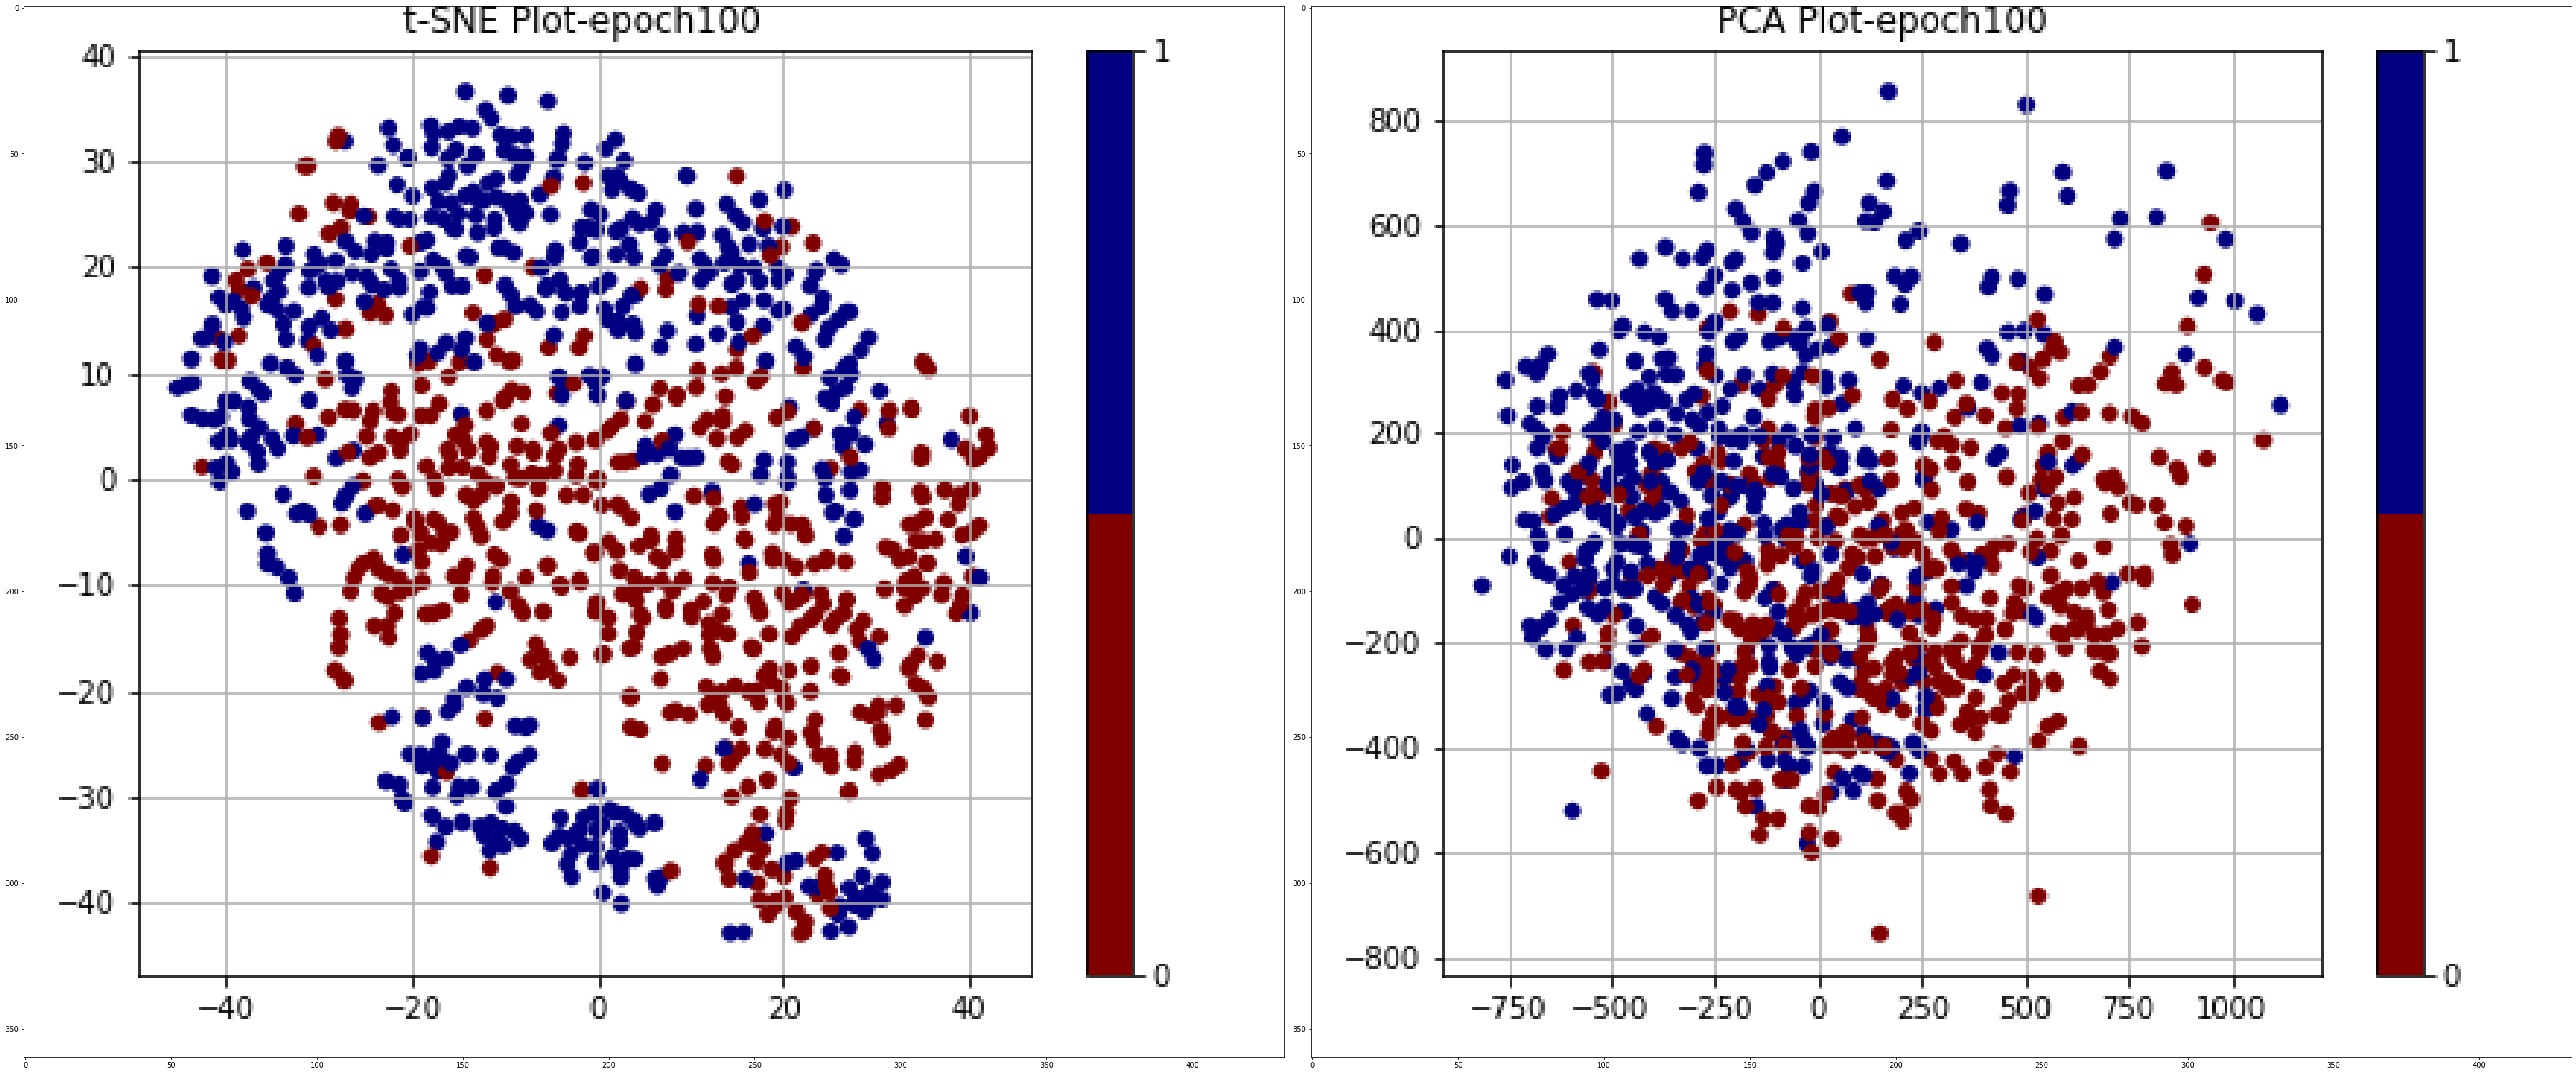

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 30))
axes[0].imshow(tsne_plt)
axes[1].imshow(pca_plt)
fig.tight_layout()

In [24]:
labels = test_df['class']
losses = test_df['G_score']

AUC: 0.74352


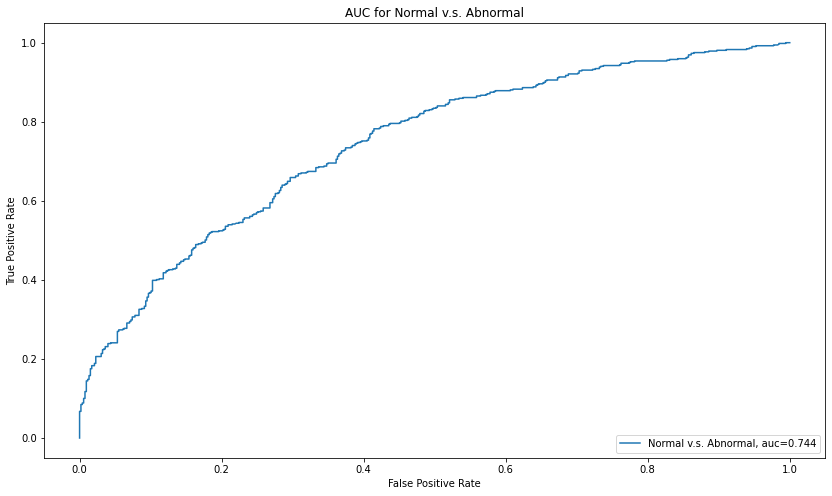

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(labels, losses, pos_label=1)
print('AUC: {:.5f}'.format(metrics.auc(fpr, tpr)))


auc = metrics.roc_auc_score(labels, losses)
plt.figure(figsize=(14,8))
plt.plot(fpr,tpr,label="Normal v.s. Abnormal, auc="+str("%.3f" % auc))
plt.title('AUC for Normal v.s. Abnormal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

# Works Cited

[1] Zhang , Jianpeng. et al, "Viral Pneumonia Screening on Chest X-ray Images Using Confidence-Aware Anomaly Detection," arXiv:2003.12338, 2020.
